In [1]:
import numpy as np
import fitsio
import healpy as hp
import Config

In [2]:
G, R, I, Z = 0, 1, 2, 3
bands = [G, R, I, Z]
exp = 11
res = 2**exp

In [3]:
validPixels = np.full(12*(res**2), True, dtype = bool)

In [4]:
condSigExtAir = []

for band in bands:
    condFile = Config.orgAirFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtAir.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels
    
print(len(condMap))
print(len(condSigExt))

201326592
50331648


In [5]:
condSigExtExp = []

for band in bands:
    condFile = Config.orgExpFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtExp.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels

In [6]:
condSigExtVar = []

for band in bands:
    condFile = Config.orgVarFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtVar.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels

In [7]:
condSigExtBri = []

for band in bands:
    condFile = Config.orgBriFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtBri.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels

In [8]:
condSigExtSee = []

for band in bands:
    condFile = Config.orgSeeFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtSee.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels

In [9]:
condSigExtZpt = []

for band in bands:
    condFile = Config.orgZptFiles[band]
    condMap = hp.fitsfunc.read_map(condFile, nest = True)
    condMap[condMap==-1.6375e+30]=hp.UNSEEN
    condSigExt=hp.ud_grade(condMap, res)
    condSigExtZpt.append(condSigExt)
    tempValidPixels = np.full(12*(res**2), False, dtype = bool)
    tempValidPixels[np.where((condSigExt >= 0))[0]] = True
    validPixels = validPixels & tempValidPixels

In [10]:
stelData = fitsio.read(Config.orgDensFile)
stelDensExt = stelData['I'].flatten()
stelDensExt[stelDensExt==-1.6375e+30]=hp.UNSEEN
condSigExtDens=hp.ud_grade(stelDensExt,res)
tempValidPixels = np.full(12*(res**2), False, dtype = bool)
tempValidPixels[np.where((condSigExtDens >= 0))[0]] = True
validPixels = validPixels & tempValidPixels

In [11]:
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# Everything from here on out is simply used in order to filter the data
DETECTED = starData['detected'] # This specifically is used for now to filter out any non detected injection.
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']
# i_mag = starData['meas_cm_mag_deredden'][:,2] This gets used if we filter at all based on i magnitude.

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      # (GOLDSOF < 2) &
                      (ARCSECONDS < 2))[0]

aveEff = np.sum(DETECTED) / len(DETECTED)

DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)
tempValidPixels = np.full(12*(res**2), False, dtype = bool)
tempValidPixels[starPixels] = True


validStarPixels = validPixels & tempValidPixels

In [12]:
print(np.sum(validStarPixels))
print(np.sum(validPixels))

790697
6953031


In [13]:
print(np.where(validStarPixels)[0])

[    2605     2606     2607 ... 49285702 49285705 49285708]


In [14]:
from astropy.table import Table

In [31]:
my_table = Table()
# add columns to the table:
my_table['PIX_2048'] = np.where(validStarPixels)[0]
# e.g. my_table['pixels'] = pixel_array

In [32]:
condSig = condSigExtAir[G][validStarPixels]
my_table['AIRMASS_G'] = condSig

In [33]:
condSig = condSigExtAir[R][validStarPixels]
my_table['AIRMASS_R'] = condSig

In [34]:
condSig = condSigExtAir[I][validStarPixels]
my_table['AIRMASS_I'] = condSig

In [35]:
condSig = condSigExtAir[Z][validStarPixels]
my_table['AIRMASS_Z'] = condSig

In [36]:
condSig = condSigExtExp[G][validStarPixels]
my_table['EXP_TIME_G'] = condSig

In [37]:
condSig = condSigExtExp[R][validStarPixels]
my_table['EXP_TIME_R'] = condSig

In [38]:
condSig = condSigExtExp[I][validStarPixels]
my_table['EXP_TIME_I'] = condSig

In [39]:
condSig = condSigExtExp[Z][validStarPixels]
my_table['EXP_TIME_Z'] = condSig

In [40]:
condSig = condSigExtVar[G][validStarPixels]
my_table['SKY_VARIANCE_G'] = condSig

condSig = condSigExtVar[R][validStarPixels]
my_table['SKY_VARIANCE_R'] = condSig

condSig = condSigExtVar[I][validStarPixels]
my_table['SKY_VARIANCE_I'] = condSig

condSig = condSigExtVar[Z][validStarPixels]
my_table['SKY_VARIANCE_Z'] = condSig

In [41]:
condSig = condSigExtBri[G][validStarPixels]
my_table['SKYBRITE_G'] = condSig

condSig = condSigExtBri[R][validStarPixels]
my_table['SKYBRITE_R'] = condSig

condSig = condSigExtBri[I][validStarPixels]
my_table['SKYBRITE_I'] = condSig

condSig = condSigExtBri[Z][validStarPixels]
my_table['SKYBRITE_Z'] = condSig

In [42]:
condSig = condSigExtSee[G][validStarPixels]
my_table['SEEING_G'] = condSig

condSig = condSigExtSee[R][validStarPixels]
my_table['SEEING_R'] = condSig

condSig = condSigExtSee[I][validStarPixels]
my_table['SEEING_I'] = condSig

condSig = condSigExtSee[Z][validStarPixels]
my_table['SEEING_Z'] = condSig

In [43]:
condSig = condSigExtZpt[G][validStarPixels]
my_table['ZPT_G'] = condSig

condSig = condSigExtZpt[R][validStarPixels]
my_table['ZPT_R'] = condSig

condSig = condSigExtZpt[I][validStarPixels]
my_table['ZPT_I'] = condSig

condSig = condSigExtZpt[Z][validStarPixels]
my_table['ZPT_Z'] = condSig

In [44]:
condSig = condSigExtDens[validStarPixels]
my_table['STELLAR_DENSITY'] = condSig

In [45]:
my_table.write("/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/valid_pixel_2048_conditions.fits", overwrite = True)

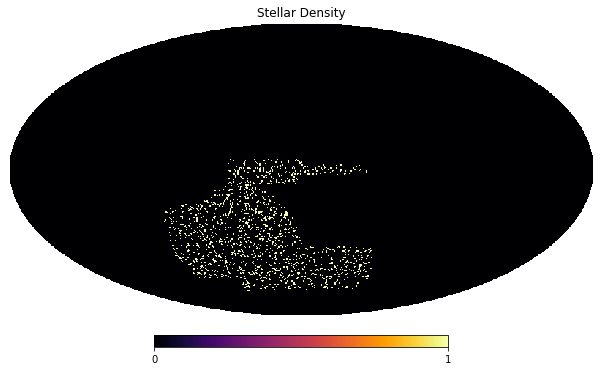

In [30]:
hp.mollview(validStarPixels, nest=True, title="Stellar Density", max = 1, min = 0, badcolor = 'black', cmap = 'inferno')